## Data Gathering

### Data info
The data we use is based on King County data which has geolocation. This data has been collected in 2014-2015
id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
- id - house ID
- date - sell date
- price - sell price
- bedrooms - no of bedrooms
- bathrooms - no of bathrooms(A bathroom without any shower or van is considered 0.5)
- sqft_living - usable interior space
- sqft_lot - the space of the land(Not sure so dropped, dataset didnt have any explinations on Kaggle)
- floors - no of floors
- waterfront - ?
- view - ?
- condition - house overall condition
- grade - ?
- sqft_above - ?
- sqft_basement - basement space
- yr_built,yr_renovated - years for construction and renovation
- zipcode,lat,long - geolocation

### Data mods
First of all we want to remodel the dataset:
- Drop unuseful columns from dataset
- Convert in eur currency/measure units



In [2]:
import pandas as pd

def convert_sqft_to_sqm(value):
    return value * 0.092903

def convert_dollars_to_euros(value):
    return value * 0.92

df = pd.read_csv('../data/kc_house_data.csv')  

# Drop the columns that are not useful for the analysis: sqm_lot,waterfront,view,sqm_above,sqm_basement,zipcode

columns_to_drop = ['id','date','sqft_lot', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'zipcode']

df.drop(columns=columns_to_drop, inplace=True)

# Convert the columns from sqft to sqm and from dollars to euros
df['sqft_living'] = df['sqft_living'].apply(convert_sqft_to_sqm)
df['price'] = df['price'].apply(convert_dollars_to_euros)

new_column_names = {
    'sqft_living': 'sqm_living',
}
df.rename(columns=new_column_names, inplace=True)

df.to_csv('../data/prefinal_dataset.csv', index=False)

print("Conversion done! Check the 'prefinal_dataset.csv' file in the 'data' folder.")

Conversion done! Check the 'prefinal_dataset.csv' file in the 'data' folder.


#### Now we have to create and colect info about every graph to take the measurements on based on lat and long

In [3]:

import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt


def download_osm_data(location):
    """
    Download OpenStreetMap data for a specified location.
    """
    # Graph from OSM data
    G = ox.graph_from_place(location, network_type='walk')
    return G


def extract_poi_subgraph(G, poi_coords, radius=1250):
    """
    Extract a subgraph around a point of interest within a certain radius (in meters).
    """
    amenities = [
        'hospital', 'clinic', 'doctors', 'pharmacy', 'dentist',
        'school', 'college', 'kindergarten', 'university', 'library', 'music_school',
        'supermarket', 'marketplace', 'mall', 'bank', 'bureau_de_change',
        'restaurant', 'cafe', 'bar', 'pub', 'biergarten',
        'theatre', 'cinema', 'museum', 'arts_centre', 'gallery',
        'bus_station', 'ferry_terminal', 'taxi', 'car_rental', 'bicycle_rental', 'car_sharing',
        'park', 'stadium', 'swimming_pool', 'sports_centre'
    ]
    # Get the nearest node to the POI
    nearest_node = ox.distance.nearest_nodes(G, poi_coords[1], poi_coords[0])
    
    # fetch amenities
    try:
        poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)
        
    except Exception as e:
        print(e)
        return None, None, None
    
    # Generate a subgraph around the nearest node within the specified radius
    subgraph = nx.ego_graph(G, nearest_node, radius=radius, distance='length')
    
    return subgraph, poi_df, nearest_node


def plot_graph(G):
    """
    Plot the graph.
    """
    fig, ax = ox.plot_graph(G, show=False, close=False)
    plt.show()

In [4]:
location = 'King County, Washington, USA'
# download OSM data
G = download_osm_data(location)

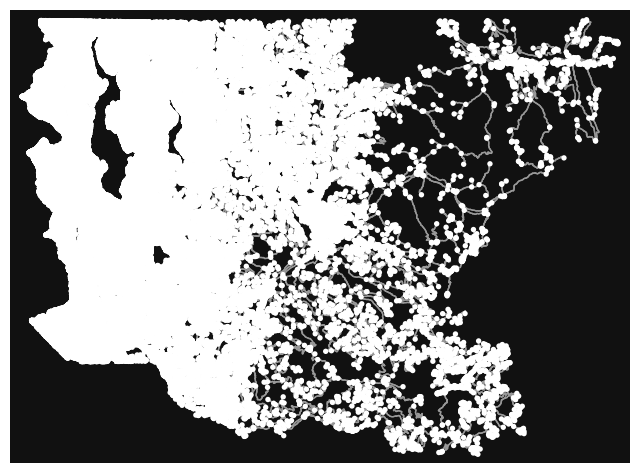

In [5]:
plot_graph(G)

Access to function: <function clustering_coef at 0x0000014D00244790>


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\4149836439.py:19: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)
C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


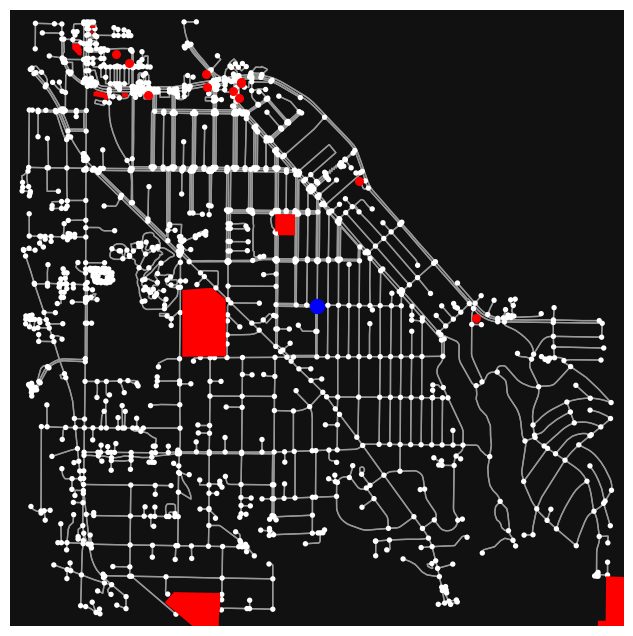

                                   alt_name     amenity  atm      brand  \
element_type osmid                                                        
node         2156871565  Washington Federal        bank  yes  WaFd Bank   
             2446638577                 NaN  restaurant  NaN        NaN   
             2446638590                 NaN        cafe  NaN        NaN   
             2446638616                 NaN  restaurant  NaN        NaN   
             5730670747                 NaN        cafe  NaN  Starbucks   

                        brand:wikidata drive_through               name  \
element_type osmid                                                        
node         2156871565       Q7971859           yes          WaFd Bank   
             2446638577            NaN           NaN  Drae's Lake Route   
             2446638590            NaN           NaN       Redwing Cafe   
             2446638616            NaN           NaN   Rainier Crawfish   
             5730670747 

In [7]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import sklearn

import sys
import os

utils_path = os.path.join(os.getcwd(), '..', 'utils')  # Assumes utils is one directory up from the script
sys.path.append(utils_path)
# Import utils file
from utils import clustering_coef

# Test if the function can be accessed
print("Access to function:", clustering_coef)

# Set up configuration for osmnx
ox.config(use_cache=True, log_console=True)

# Function to fetch points of interest and graph
def fetch_pois(lat, lon, dist=1250, network_type='walk', plot=True):
    point = (lat, lon)
    try:
        G = ox.graph_from_point(point, dist=dist, network_type=network_type, simplify=True)
        amenities = [
            'hospital', 'clinic', 'doctors', 'pharmacy', 'dentist',
            'school', 'college', 'kindergarten', 'university', 'library', 'music_school',
            'supermarket', 'marketplace', 'mall', 'bank', 'bureau_de_change',
            'restaurant', 'cafe', 'bar', 'pub', 'biergarten',
            'theatre', 'cinema', 'museum', 'arts_centre', 'gallery',
            'bus_station', 'ferry_terminal', 'taxi', 'car_rental', 'bicycle_rental', 'car_sharing',
            'park', 'stadium', 'swimming_pool', 'sports_centre'
        ]
        pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)
        nearest_node = ox.distance.nearest_nodes(G, lon, lat)

    except Exception as e:
        print(f"Error fetching POIs for location ({lat}, {lon}): {e}")
        return None, None, None

    if plot and G is not None:
        fig, ax = ox.plot_graph(G, show=False, close=False)
        pois['geometry'].plot(ax=ax, color='red', markersize=30)
        x, y = G.nodes[nearest_node]['x'], G.nodes[nearest_node]['y']
        ax.scatter(x, y, color='blue', s=100, zorder=5)
        plt.show()
        return G, pois, nearest_node
    return G, pois, nearest_node

# Load your data
df = pd.read_csv('../data/prefinal_dataset.csv')

# Fetch POIs for the first location
lat, lon = df['lat'][0], df['long'][0]
graph, points_of_interest, nearest_node = fetch_pois(lat, lon)
print(points_of_interest.head())  # Display some of the POIs
print("Nearest node:", nearest_node)

# Perform your analysis here
# Average node degree
print("Average node degree:", sum(dict(graph.degree()).values()) / len(graph.nodes))

#measure degree centrality
degree_centrality = nx.degree_centrality(graph)
print("Degree centrality:", degree_centrality[nearest_node])

# Measure betweenness centrality
betweenness_centrality = nx.betweenness_centrality(graph)
print("Betweenness centrality:", betweenness_centrality[nearest_node])

# Measure closeness centrality
closeness_centrality = nx.closeness_centrality(graph)
print("Closeness centrality:", closeness_centrality[nearest_node])

# Measure graph density and average path length
density = nx.density(graph)
print("Graph density:", density)

#### Doing the example for all samples

!!! DONT START A FULL RUN ON THIS YET

In [9]:
import numpy as np

# Load data
df = pd.read_csv('../data/final_dataset.csv')

max_iterations = 5000
start_index = 1

for index, row in df.iterrows():
    if index < start_index:
        continue
    if index >= start_index + max_iterations:
        print("Max iterations reached.")
        break

    lat = row['lat']
    lon = row['long']
    check = row['avg_degree']
    if np.isnan(check) == False:
        print(f"Index {index} already processed, skip.")
        max_iterations += 1
        continue

    subGraph, pointOfInterest, nearestNode = extract_poi_subgraph(G, (lat, lon))
    if subGraph is None or pointOfInterest is None or nearestNode is None:
        print(f"Error processing index {index}, skip.")
        continue

    avg_degree = sum(dict(subGraph.degree()).values()) / len(subGraph.nodes)
    degree_centrality = nx.degree_centrality(subGraph)
    betweenness_centrality = nx.betweenness_centrality(subGraph)
    closeness_centrality = nx.closeness_centrality(subGraph)
    density = nx.density(subGraph)

    df.at[index, 'avg_degree'] = avg_degree
    df.at[index, 'degree_centrality'] = degree_centrality[nearestNode]
    df.at[index, 'betweenness_centrality'] = betweenness_centrality[nearestNode]
    df.at[index, 'closeness_centrality'] = closeness_centrality[nearestNode]
    df.at[index, 'density'] = density
    print("Done for index:", index)

    # save the updated dataframe
    df.to_csv('../data/final_dataset.csv', index=False)


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19000


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19001


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19002, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19003


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19004


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19005


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19006


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19007


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19008


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19009


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19010


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19011


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19012


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19013


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19014


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19015


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19016


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19017


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19018


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19019


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19020


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19021


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19022


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19023


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19024


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19025


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19026


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19027


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19028


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19029


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19030


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19031, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19032


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19033


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19034


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19035


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19036


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19037


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19038


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19039


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19040


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19041


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19042


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19043


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19044


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19045


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19046


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19047


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19048


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19049


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19050


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19051


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19052


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19053


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19054


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19055


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19056


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19057


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19058


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19059


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19060


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19061


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19062


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19063


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19064


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19065


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19066


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19067


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19068


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19069


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19070


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19071


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19072


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19073


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19074


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19075


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19076


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19077


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19078


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19079


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19080


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19081


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19082


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19083


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19084


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19085


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19086


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19087


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19088


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19089


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19090


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19091, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19092, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19093


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19094


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19095


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19096


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19097


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19098


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19099


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19100


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19101, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19102


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19103


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19104


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19105


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19106


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19107


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19108


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19109


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19110


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19111


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19112


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19113, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19114


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19115


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19116


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19117


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19118


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19119


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19120


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19121


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19122


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19123


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19124


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19125


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19126


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19127


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19128


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19129


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19130


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19131


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19132


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19133


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19134


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19135


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19136


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19137


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19138


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19139


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19140


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19141


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19142


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19143


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19144


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19145


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19146


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19147


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19148


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19149


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19150


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19151


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19152


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19153


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19154


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19155


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19156, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19157


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19158


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19159


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19160


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19161


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19162


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19163


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19164


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19165


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19166


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19167


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19168


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19169


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19170


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19171


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19172


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19173


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19174


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19175


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19176


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19177


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19178


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19179


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19180


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19181, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19182


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19183


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19184


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19185


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19186


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19187


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19188


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19189


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19190


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19191


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19192


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19193


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19194


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19195


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19196


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19197


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19198


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19199


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19200


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19201


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19202


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19203


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19204


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19205


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19206


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19207


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19208


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19209


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19210


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19211


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19212


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19213


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19214


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19215


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19216


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19217


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19218


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19219


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19220


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19221


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19222


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19223


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19224


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19225


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19226


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19227


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19228


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19229


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19230


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19231, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19232


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19233


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19234


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19235


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19236


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19237


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19238


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19239


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19240


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19241


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19242


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19243


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19244


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19245


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19246


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19247


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19248


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19249


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19250


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19251


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19252, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19253


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19254


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19255


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19256


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19257


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19258


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19259


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19260


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19261


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19262


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19263


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19264


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19265


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19266


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19267


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19268


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19269


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19270


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19271


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19272


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19273


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19274


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19275


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19276


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19277


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19278


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19279


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19280


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19281


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19282


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19283


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19284


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19285


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19286


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19287


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19288


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19289


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19290


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19291


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19292


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19293


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19294


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19295


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19296


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19297


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19298


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19299


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19300


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19301


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19302


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19303


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19304


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19305


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19306


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19307


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19308


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19309


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19310


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19311


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19312


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19313


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19314


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19315


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19316


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19317


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19318


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19319


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19320


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19321


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19322


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19323


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19324


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19325


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19326


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19327


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19328


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19329


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19330


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19331


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19332


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19333


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19334


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19335


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19336


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19337


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19338, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19339


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19340


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19341


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19342


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19343


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19344


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19345


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19346


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19347


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19348


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19349


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19350


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19351


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19352


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19353


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19354


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19355


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19356


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19357


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19358


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19359


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19360


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19361


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19362


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19363


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19364


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19365


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19366


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19367, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19368


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19369


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19370


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19371


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19372


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19373


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19374


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19375


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19376


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19377


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19378


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19379


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19380


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19381


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19382


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19383


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19384


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19385


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19386


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19387, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19388


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19389


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19390


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19391


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19392


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19393


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19394


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19395


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19396


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19397


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19398


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19399


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19400


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19401


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19402


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19403


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19404


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19405


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19406


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19407


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19408


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19409


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19410


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19411


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19412


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19413


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19414


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19415


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19416


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19417


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19418


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19419


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19420


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19421


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19422


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19423


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19424


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19425


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19426


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19427


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19428


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19429


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19430


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19431


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19432


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19433


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19434, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19435


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19436


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19437


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19438


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19439, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19440


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19441


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19442


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19443


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19444


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19445


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19446


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19447


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19448


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19449


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19450


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19451


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19452


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19453


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19454


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19455


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19456


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19457


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19458


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19459


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19460


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19461


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19462, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19463


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19464


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19465


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19466


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19467


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19468


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19469


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19470


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19471


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19472


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19473


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19474


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19475


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19476


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19477


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19478


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19479


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19480


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19481


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19482


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19483


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19484


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19485


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19486


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19487


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19488


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19489


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19490


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19491


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19492


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19493


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19494


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19495


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19496


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19497


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19498, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19499


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19500


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19501


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19502


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19503


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19504


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19505


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19506


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19507


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19508


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19509


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19510


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19511


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19512


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19513


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19514


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19515


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19516


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19517


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19518


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19519


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19520


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19521


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19522


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19523


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19524


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19525


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19526


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19527


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19528


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19529


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19530


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19531


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19532


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19533


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19534


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19535


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19536


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19537


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19538


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19539


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19540


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19541


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19542


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19543


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19544


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19545


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19546


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19547


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19548


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19549


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19550


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19551


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19552


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19553


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19554


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19555


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19556


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19557


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19558


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19559


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19560


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19561


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19562


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19563


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19564


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19565


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19566, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19567


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19568


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19569


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19570


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19571


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19572


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19573


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19574


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19575


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19576


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19577


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19578


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19579


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19580


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19581


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19582


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19583


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19584


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19585


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19586


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19587


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19588


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19589


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19590


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19591


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19592


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19593


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19594, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19595


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19596


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19597


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19598


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19599


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19600


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19601


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19602


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19603


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19604


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19605


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19606


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19607


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19608


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19609


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19610


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19611


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19612


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19613


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19614


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19615


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19616


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19617


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19618


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19619


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19620


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19621


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19622


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19623


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19624


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19625


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19626


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19627


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19628


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19629


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19630


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19631


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19632


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19633


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19634


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19635


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19636


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19637


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19638


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19639


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19640


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19641


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19642


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19643


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19644


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19645


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19646


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19647


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19648


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19649


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19650


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19651


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19652


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19653


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19654


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19655


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19656


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19657


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19658


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19659


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19660


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19661


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19662


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19663


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19664


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19665


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19666


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19667


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19668


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19669


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19670


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19671


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19672


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19673


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19674


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19675


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19676


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19677


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19678


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19679


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19680, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19681


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19682


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19683


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19684


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19685


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19686


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19687


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19688


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19689


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19690


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19691


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19692


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19693


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19694


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19695


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19696


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19697


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19698


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19699


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19700


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19701


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19702


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19703


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19704


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19705


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19706


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19707


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19708


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19709


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19710


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19711


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19712


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19713


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19714


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19715


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19716


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19717


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19718


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19719


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19720


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19721


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19722


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19723


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19724


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19725


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19726


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19727


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19728


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19729


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19730


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19731


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19732


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19733


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19734


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19735


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19736


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19737


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19738


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19739


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19740


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19741


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19742


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19743


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19744


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19745


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19746


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19747


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19748


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19749


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19750


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19751


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19752


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19753


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19754


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19755


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19756


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19757


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19758


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19759


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19760


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19761


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19762


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19763


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19764


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19765


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19766


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19767


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19768


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19769


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19770


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19771


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19772


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19773


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19774


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19775


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19776


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19777


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19778


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19779


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19780


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19781


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19782


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19783


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19784


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19785


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19786


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19787


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19788


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19789


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19790


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19791


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19792


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19793


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19794


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19795


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19796


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19797


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19798


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19799


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19800, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19801


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19802


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19803


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19804


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19805


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19806


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19807


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19808


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19809


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19810


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19811


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19812


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19813


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19814


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19815


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19816


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19817


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19818


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19819


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19820


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19821


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19822


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19823


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19824


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19825


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19826


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19827


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19828


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19829


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19830


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19831


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19832


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19833


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19834


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19835


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19836


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19837


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19838


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19839


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19840


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19841


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19842


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19843


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19844


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19845


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19846


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19847


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19848


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19849


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19850, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19851


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19852


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19853


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19854


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19855


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19856


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19857


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19858


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19859


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19860


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19861


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19862


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19863


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19864


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19865


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19866


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19867


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19868


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19869


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19870


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19871


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19872


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19873


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19874


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19875


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19876


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19877


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19878


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19879


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19880


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19881


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19882


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19883


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19884


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19885


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19886


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19887


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19888


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19889


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19890


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19891


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19892


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19893, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19894


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19895


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19896


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19897


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19898


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19899


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19900


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19901


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19902


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19903


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19904


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19905


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19906


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19907


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19908


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19909


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19910


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19911


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19912


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19913


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19914


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19915


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19916


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19917


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19918


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19919


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19920


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19921


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19922


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19923


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19924


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19925


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19926


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19927


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19928


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19929


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19930


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19931


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19932


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19933


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19934


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19935


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19936


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19937


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19938


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19939


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19940


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19941


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19942


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19943


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19944, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19945


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19946


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19947


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19948


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19949


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19950


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19951


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19952


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19953


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19954


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19955


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19956


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19957


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19958


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19959


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19960


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19961


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19962


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19963


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19964


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19965


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19966


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19967


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19968


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19969


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19970


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19971, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19972


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19973


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19974


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19975


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19976


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19977, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19978


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19979


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19980, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19981


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19982


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19983


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19984


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19985


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19986


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19987


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19988


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19989


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19990


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19991


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19992


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19993


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19994


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19995


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19996


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19997


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19998


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 19999


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20000


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20001


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20002


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20003


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20004


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20005


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20006


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20007


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20008


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20009


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20010


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20011


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20012


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20013


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20014


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20015


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20016


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20017


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20018


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20019


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20020


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20021


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20022


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20023


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20024


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20025


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20026


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20027


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20028


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20029


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20030


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20031


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20032


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20033


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20034


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20035


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20036


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20037, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20038


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20039


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20040


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20041


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20042


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20043


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20044


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20045


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20046


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20047


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20048


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20049


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20050


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20051


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20052


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20053


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20054


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20055


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20056


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20057


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20058


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20059


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20060


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20061


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20062


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20063


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20064


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20065


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20066


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20067


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20068


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20069


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20070


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20071


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20072


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20073


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20074


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20075


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20076


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20077


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20078


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20079


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20080


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20081


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20082


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20083


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20084


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20085


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20086


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20087


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20088


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20089


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20090


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20091


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20092


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20093


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20094


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20095


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20096


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20097


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20098


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20099


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20100


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20101


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20102


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20103


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20104


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20105


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20106


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20107


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20108


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20109


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20110


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20111


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20112


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20113


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20114


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20115


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20116


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20117


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20118


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20119


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20120


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20121


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20122


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20123


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20124


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20125


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20126


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20127


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20128


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20129


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20130


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20131


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20132


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20133


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20134


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20135


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20136


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20137


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20138


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20139


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20140


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20141, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20142


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20143


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20144


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20145


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20146


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20147


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20148


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20149


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20150


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20151


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20152, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20153


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20154


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20155


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20156


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20157


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20158


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20159


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20160


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20161


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20162


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20163


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20164


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20165


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20166


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20167


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20168


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20169


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20170


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20171


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20172


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20173


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20174


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20175


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20176


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20177


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20178


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20179


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20180


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20181


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20182


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20183


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20184


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20185


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20186


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20187


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20188


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20189


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20190


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20191


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20192


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20193


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20194


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20195


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20196


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20197


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20198


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20199


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20200


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20201


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20202


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20203, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20204


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20205


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20206


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20207


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20208


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20209


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20210


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20211


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20212


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20213


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20214


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20215


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20216


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20217


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20218


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20219


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20220


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20221


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20222


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20223


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20224


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20225


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20226


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20227


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20228


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20229


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20230


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20231


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20232


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20233


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20234


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20235


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20236


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20237


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20238


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20239


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20240


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20241


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20242


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20243


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20244


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20245


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20246


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20247


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20248


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20249


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20250


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20251


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20252


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20253


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20254


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20255


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20256


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20257


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20258


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20259


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20260


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20261


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20262


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20263


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20264


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20265


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20266


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20267


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20268


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20269


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20270


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20271


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20272


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20273


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20274


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20275


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20276


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20277


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20278


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20279


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20280


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20281


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20282


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20283


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20284


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20285


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20286


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20287


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20288


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20289


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20290, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20291


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20292


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20293


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20294


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20295


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20296


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20297


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20298


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20299


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20300


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20301


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20302


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20303


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20304


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20305


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20306


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20307


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20308


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20309


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20310


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20311


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20312


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20313


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20314


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20315


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20316


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20317


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20318


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20319


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20320


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20321


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20322


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20323


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20324


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20325


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20326


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20327


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20328


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20329


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20330


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20331


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20332


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20333


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20334


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20335


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20336


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20337


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20338


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20339


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20340


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20341


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20342


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20343


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20344


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20345


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20346


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20347


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20348


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20349


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20350


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20351


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20352


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20353


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20354


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20355


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20356


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20357


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20358


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20359


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20360


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20361


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20362


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20363


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20364


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20365


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20366


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20367


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20368


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20369


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20370


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20371


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20372


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20373


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20374


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20375


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20376


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20377


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20378


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20379


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20380


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20381


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20382


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20383


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20384


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20385


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20386, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20387


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20388


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20389


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20390


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20391


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20392


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20393


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20394


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20395


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20396


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20397


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20398


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20399


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20400


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20401


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20402


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20403


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20404


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20405


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20406


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20407


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20408


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20409


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20410


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20411


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20412


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20413


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20414


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20415


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20416


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20417


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20418


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20419


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20420


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20421


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20422


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20423


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20424


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20425, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20426


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20427


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20428


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20429


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20430


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20431


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20432


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20433


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20434


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20435


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20436


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20437


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20438


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20439


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20440


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20441


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20442


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20443


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20444


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20445


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20446


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20447


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20448


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20449


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20450


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20451


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20452, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20453


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20454


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20455


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20456


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20457


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20458


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20459


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20460


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20461


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20462


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20463


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20464


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20465


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20466


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20467


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20468


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20469


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20470


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20471, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20472


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20473


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20474


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20475


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20476


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20477


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20478


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20479


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20480


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20481


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20482


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20483


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20484


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20485


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20486


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20487


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20488


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20489


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20490


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20491


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20492


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20493


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20494


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20495


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20496


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20497


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20498


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20499


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20500


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20501


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20502


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20503


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20504


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20505


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20506


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20507


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20508


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20509


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20510


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20511


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20512


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20513


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20514


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20515


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20516


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20517


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20518


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20519


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20520


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20521


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20522


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20523


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20524


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20525


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20526


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20527


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20528


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20529


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20530


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20531


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20532


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20533


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20534


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20535


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20536


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20537


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20538


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20539


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20540


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20541


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20542


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20543


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20544


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20545


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20546


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20547


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20548


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20549


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20550


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20551


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20552


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20553


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20554


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20555


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20556


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20557


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20558


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20559


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20560


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20561


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20562


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20563


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20564


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20565


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20566


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20567


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20568


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20569


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20570


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20571


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20572


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20573


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20574


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20575


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20576


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20577


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20578


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20579


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20580


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20581


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20582


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20583


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20584


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20585


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20586


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20587


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20588


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20589


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20590


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20591


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20592


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20593


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20594


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20595


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20596


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20597


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20598


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20599


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20600


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20601


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20602


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20603


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20604


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20605


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20606


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20607


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20608


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20609


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20610


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20611


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20612


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20613
Max iterations reached.
